# Cell Basic Filtering

## Content
The purpose of this step is to get rid of cells having **obvious** issues, including the cells with low mapping rate (potentially contaminated), low final reads (empty well or lost a large amount of DNA during library prep.), or abnormal methylation fractions (failed in bisulfite conversion or contaminated).

We have two principles when applying these filters:
1. **We set the cutoff based on the distribution of the whole dataset**, where we assume the input dataset is largely successful (mostly > 80-90% cells will pass QC). The cutoffs below are typical values we used in brain methylome analysis. Still, you may need to adjust cutoffs based on different data quality or sample source.
2. **The cutoff is intended to be loose.** We do not use stringent cutoffs here to prevent potential data loss. Abormal cells may remain after basic filtering, and will likely be identified in the analysis based filtering (see later notebooks about doublet score and outliers in clustering)

## Input
- Cell metadata table that contains mapping metric for basic QC filtering.

## Output
- Filtered cell metadata table that contains only cells passed QC.

## About Cell Mapping Metrics
We usually gather many mapping metrics from each processing step, but not all of the metrics are relevant to the cell filtering. Below are the most relevant metrics that we use to filter cells. The name of these metrics might be different in your dataset. Change it according to the file you have.

If you use [YAP](https://hq-1.gitbook.io/mc) to do mapping, you can find up-to-date mapping metrics documentation for [key metrics](https://hq-1.gitbook.io/mc/mapping-metrics/key-mapping-metrics) and [all metrics](https://hq-1.gitbook.io/mc/mapping-metrics/all-mapping-metrics) in YAP doc.

## Import

In [1]:
import pandas as pd
import seaborn as sns

for pkg in [pd, sns]:
    print(pkg.__name__, pkg.__version__)

pandas 1.1.4
seaborn 0.11.1


In [2]:
sns.set_context(context='notebook', font_scale=1.3)

## Parameters

In [3]:
# change this to the path to your metadata
metadata_path = '../../../data/Brain/MOp+CA.CellMetadata.csv.gz'

# Basic filtering parameters
mapping_rate_cutoff = 0.5
mapping_rate_col_name = 'MappingRate'  # Name may change
final_reads_cutoff = 500000
final_reads_col_name = 'FinalmCReads'  # Name may change
mccc_cutoff = 0.03
mccc_col_name = 'mCCCFrac'  # Name may change
mch_cutoff = 0.2
mch_col_name = 'mCHFrac'  # Name may change
mcg_cutoff = 0.5
mcg_col_name = 'mCGFrac'  # Name may change

## Load metadata

In [4]:
metadata = pd.read_csv(metadata_path, index_col=0)
total_cells = metadata.shape[0]
print(f'Metadata of {total_cells} cells')

Metadata of 5535 cells


In [5]:
metadata.head()

,mCCCFrac,mCGFrac,mCHFrac,FinalmCReads,CellInputReadPairs,MappingRate,Plate,Col384,Row384,CellTypeAnno
cell,,,,,,,,,,
3C_M_0,0.00738,0.75953,0.02543,1195574.0,2896392,0.625773,CEMBA171206-3C-1,18,0,IT-L23
3C_M_1,0.00938,0.77904,0.03741,1355517.0,3306366,0.631121,CEMBA171206-3C-1,18,1,IT-L5
3C_M_10,0.00915,0.82430,0.03678,2815807.0,7382298,0.657560,CEMBA171206-3C-1,21,1,L6b
3C_M_100,0.00978,0.79705,0.04231,2392650.0,5865154,0.671600,CEMBA171206-3C-1,0,3,MGE-Pvalb
3C_M_1000,0.00776,0.78781,0.02789,1922013.0,4800236,0.646285,CEMBA171206-3C-4,3,8,IT-L6


## Filter by key mapping metrics

### Bismark Mapping Rate

- Low mapping rate indicates potential contamination.
- Usually R1 mapping rate is 8-10% higher than R2 mapping rate for snmC based technologies, but they should be highly correlated. Here I am using the combined mapping rate. If you are using the R1MappingRate or R2MappingRate, change the cutoff accordingly.
- Usually there is a peak on the left, which corresponding to the empty wells.

5083 / 5535 cells (91.8%) passed the MappingRate cutoff 0.5.


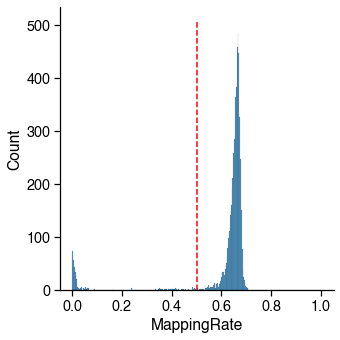

In [6]:
_cutoff = mapping_rate_cutoff
_col_name = mapping_rate_col_name

# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0, 1))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

mapping_rate_judge = metadata[_col_name] > _cutoff
_passed_cells = mapping_rate_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

### Final Reads

- The cutoff may change depending on how deep the library has been sequenced.
- Usually there is a peak on the left, which corresponding to the empty wells.
- There are also some cells having small number of reads, these wells may lost most of the DNA during library prep. Cells having too less reads can be hard to classify, since the methylome sequencing is an untargeted whole-genome sequencing.

4982 / 5535 cells (90.0%) passed the FinalmCReads cutoff 500000.


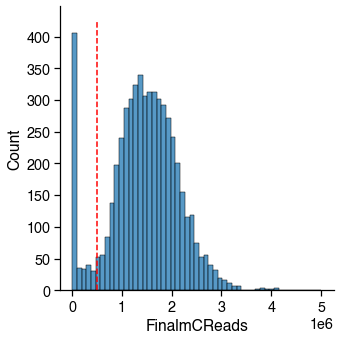

In [7]:
_cutoff = final_reads_cutoff
_col_name = final_reads_col_name

# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0, 5e6))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

final_reads_judge = metadata[_col_name] > _cutoff
_passed_cells = final_reads_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

### mCCC / CCC

- The mCCC fraction is used as the proxy of the upper bound of the non-conversion rate for cell-level QC. The methylation level at CCC sites is the lowest among all of the different 3 base-contexts (CNN), and, in fact, it is very close to the unmethylated lambda mC fraction.
- However, mCCC fraction is correlated with mCH (especially in brain data), so you can see a similar shape of distribution of mCCC and mCH, but the range is different.

5512 / 5535 cells (99.6%) passed the mCCCFrac cutoff 0.03.


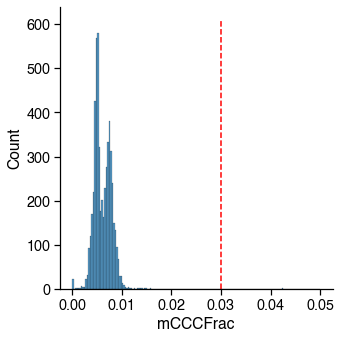

In [8]:
_cutoff = mccc_cutoff
_col_name = mccc_col_name

# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0, 0.05))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

mccc_judge = metadata[_col_name] < _cutoff
_passed_cells = mccc_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

### mCH / CH

- Usually failed cells (empty well or contaminated) tend to have abormal methylation level as well.

5532 / 5535 cells (99.9%) passed the mCHFrac cutoff 0.2.


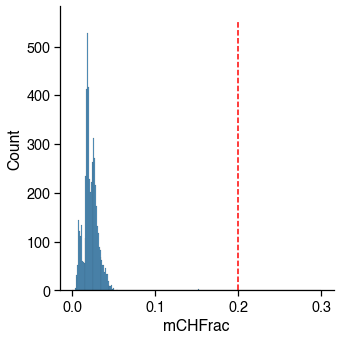

In [9]:
_cutoff = mch_cutoff
_col_name = mch_col_name

# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0, 0.3))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

mch_judge = metadata[_col_name] < _cutoff
_passed_cells = mch_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

### mCG

- Usually failed cells (empty well or contaminated) tend to have abormal methylation level as well.

5531 / 5535 cells (99.9%) passed the mCGFrac cutoff 0.5.


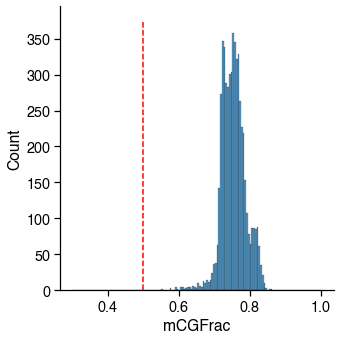

In [10]:
_cutoff = mcg_cutoff
_col_name = mcg_col_name

# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0.3, 1))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

mcg_judge = metadata[_col_name] > _cutoff
_passed_cells = mcg_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

## Combine filters

In [11]:
judge = mapping_rate_judge & final_reads_judge & mccc_judge & mch_judge & mcg_judge
passed_cells = judge.sum()
print(
    f'{passed_cells} / {total_cells} cells ({passed_cells / total_cells * 100:.1f}%) '
    f'passed all the filters.')

4958 / 5535 cells (89.6%) passed all the filters.


## Sanity Test

In [12]:
try:
    assert (passed_cells / total_cells) > 0.6
except AssertionError as e:
    e.args += (
        'A large amount of the cells do not pass filter, check your cutoffs or overall dataset quality.',
    )
    raise e

try:
    assert passed_cells > 0
except AssertionError as e:
    e.args += ('No cell remained after all the filters.', )
    raise e

print('Feel good')

Feel good


## Save filtered metadata

In [13]:
metadata_filtered = metadata[judge].copy()

metadata_filtered.to_csv('CellMetadata.PassQC.csv.gz')